# Sentiment Analysis on yelp reviews

Objective:

Classify Yelp Reviews into 1 to 5 star categories based off the text content in the reviews.

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business and serves as the rating of the business by the person who wrote the review.

For the data and more information on the dataset see https://www.kaggle.com/c/yelp-recsys-2013.


### Imports

In [87]:
import os

#EDA
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

#Data Preprocessing
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Training and Evaluation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valerie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read data

In [88]:
pwd = os.getcwd()
yelp = pd.read_csv(pwd + '/yelp.csv')

## EDA

In [91]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [92]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [93]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [94]:
#create new column text_length for EDA
yelp['text_length'] = yelp['text'].apply(len)
yelp.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


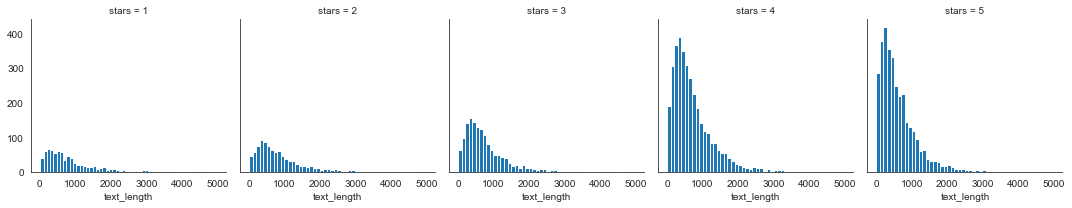

In [95]:
#explore feature text_length based on 5 star rating
sns.set_style('white')
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist, 'text_length',bins=50)
#we see much more reviews towards 4 and 5 stars

<AxesSubplot:xlabel='stars', ylabel='text_length'>

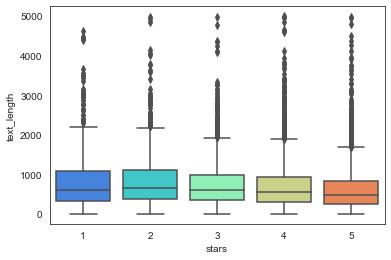

In [96]:
sns.boxplot(data=yelp,x='stars', y='text_length',palette='rainbow')
#1 and 2 star reviews have higher text length, but there are so many outliers that maybe this feature is not a good predictor

<AxesSubplot:xlabel='stars', ylabel='count'>

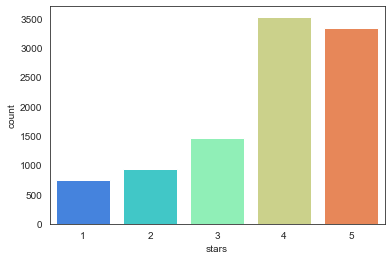

In [97]:
# number of occurences for each type of star rating
sns.countplot(data=yelp,x='stars',palette='rainbow')
#more reviews with 4 and 5 stars

In [98]:
#groupby to get mean values of stars
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [99]:
stars.corr()

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


<AxesSubplot:>

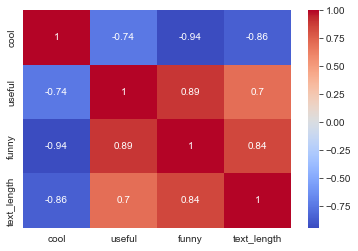

In [100]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)
#funny is highly correlated to useful
#useful is corrleatd to text_length
#negative corr. between cool with useful, funny, text_length

Conclusion:
- 1 and 2 star reviews have higher text length
-  there are more reviews with 4 and 5 stars
- useful is corrleatd to text_length
- negative correlation between cool with useful, funny, text_length

## NLP Classification task

## Train and evaluate a model

In [101]:
X = yelp['text']
y = yelp['stars']

In [102]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [103]:
#text pre-processing with pipeline
pipe_nb = Pipeline([('bow', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

In [104]:
#fit the pipe to training data
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB())])

In [105]:
predictions = pipe_nb.predict(X_test)

In [106]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[  0   0   0 187  33]
 [  0   0   0 266   7]
 [  0   0   1 422  20]
 [  0   0   0 974  90]
 [  0   0   0 708 292]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       220
           2       0.00      0.00      0.00       273
           3       1.00      0.00      0.00       443
           4       0.38      0.92      0.54      1064
           5       0.66      0.29      0.40      1000

    accuracy                           0.42      3000
   macro avg       0.41      0.24      0.19      3000
weighted avg       0.50      0.42      0.33      3000



/Users/valerie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/valerie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/valerie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is really bad! Let's try a different classifier.

In [107]:
pipe_svc = Pipeline([('bow', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

In [108]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LinearSVC())])

In [109]:
predictions = pipe_svc.predict(X_test)

print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[106  44  18  22  30]
 [ 40  81  67  60  25]
 [ 16  37 135 186  69]
 [  8  11  95 588 362]
 [  9   5  27 336 623]]


              precision    recall  f1-score   support

           1       0.59      0.48      0.53       220
           2       0.46      0.30      0.36       273
           3       0.39      0.30      0.34       443
           4       0.49      0.55      0.52      1064
           5       0.56      0.62      0.59      1000

    accuracy                           0.51      3000
   macro avg       0.50      0.45      0.47      3000
weighted avg       0.51      0.51      0.50      3000



Linear Support Vector Classification performs slightly better than Naive Bayes Classifier, but we still have really bad scores. Do some Feature Engineering and train again.

# Feature Engineering

The model couldn't really distinguish between the different labels. As the EDA showed, it could make sense to summarize the star ratings and work with fewer labels.

In [110]:
def rating(yelp):
    '''
    creates new label 'rating' to serve as the predictor instead of 'stars
    '''
    yelp.loc[(yelp['stars'] == 1) | (yelp['stars'] == 2), 'rating'] = 1
    yelp.loc[(yelp['stars'] == 3), 'rating'] = 1
    yelp.loc[(yelp['stars'] == 4) | (yelp['stars'] == 5), 'rating'] = 2
rating(yelp)

In [111]:
yelp['rating'] = yelp['rating'].astype(int)

In [112]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length,rating
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889,2
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345,2
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76,2
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419,2
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469,2


In [113]:
X_new = yelp['text']
y_new = yelp['rating']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=101)

In [115]:
pipe_fe = Pipeline([('bow', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

In [116]:
pipe_fe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LinearSVC())])

In [117]:
predictions = pipe_fe.predict(X_test)

In [118]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[ 647  289]
 [ 193 1871]]


              precision    recall  f1-score   support

           1       0.77      0.69      0.73       936
           2       0.87      0.91      0.89      2064

    accuracy                           0.84      3000
   macro avg       0.82      0.80      0.81      3000
weighted avg       0.84      0.84      0.84      3000



Not bad, we started with an accuracy of 0.42 and are now at 0.84.